# AIG200 - Milestone 2 Demo
## Group 1 - Harmful Brain Activity Classifier/Predictor
### Model: CNN
Pre-trained Model: EfficientNet-B0 <br>
No. of Datapoints: 10,000 <br>
Epochs: 10 <br>

### Creating the Data Class & Data Preprocessing

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np

class HMSSpectrogramDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file (train.csv).
            spectrogram_dir (string): Directory with all the .parquet files.
            transform (callable, optional): Optional transform to be applied
                on a sample (e.g., resizing, normalization).
        """
        self.data = pd.read_csv(csv_file)
        self.spectrogram_dir = spectrogram_dir
        self.transform = transform

        # The target columns (the votes for each class)
        self.target_cols = [
            'seizure_vote', 'lpd_vote', 'gpd_vote',
            'lrda_vote', 'grda_vote', 'other_vote'
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 1. Get row information
        row = self.data.iloc[idx]
        spec_id = int(row['spectrogram_id'])
        offset = int(row['spectrogram_label_offset_seconds'])

        # 2. Construct file path
        file_path = f"{self.spectrogram_dir}/{spec_id}.parquet"

        # 3. Load the specific parquet file
        # Note: In production, you might want to cache this or use a custom loader
        # because reading Parquet repeatedly can be slow.
        full_spectrogram = pd.read_parquet(file_path)

        # 4. Slice the data based on the offset
        # The spectrogram time starts at 0. We need the data starting at 'offset'.
        # The competition usually assumes a 10-minute window (600 seconds).
        # Since the rows in the parquet file typically represent 2 seconds each (0.5Hz),
        # we need to be careful with indexing.
        # *CHECK YOUR DATA*: Usually, the 'time' column in parquet aligns with offset.

        # Select rows where 'time' is between offset and offset + 600
        start_time = offset
        end_time = offset + 600

        # Filter the dataframe for the specific window
        window_df = full_spectrogram.loc[
            (full_spectrogram['time'] >= start_time) &
            (full_spectrogram['time'] < end_time)
        ]

        # Drop the 'time' column as it's not a feature for the CNN
        spec_data = window_df.drop(columns=['time']).values

        # 5. Handle missing values (NaNs are common in this dataset)
        # Replacing with 0 or the mean is standard.
        # Log transformation is also very common for spectrograms to normalize peaks.
        spec_data = np.nan_to_num(spec_data, nan=0.0)
        spec_data = np.log1p(spec_data) # Log transform acts as normalization

        # 6. Formatting for CNN: (Channels, Height, Width)
        # Current shape: (Time_Steps, Frequencies) -> e.g., (300, 400)
        # CNN expects: (1, 300, 400)
        spec_tensor = torch.tensor(spec_data, dtype=torch.float32).unsqueeze(0)

        # 7. Get the labels (targets)
        # Normalize votes to probabilities (sum to 1) if they aren't already
        votes = row[self.target_cols].values.astype(np.float32)
        total_votes = votes.sum()
        if total_votes > 0:
            probabilities = votes / total_votes
        else:
            # Fallback if no votes (unlikely in clean data)
            probabilities = np.zeros_like(votes)

        target = torch.tensor(probabilities, dtype=torch.float32)

        if self.transform:
            spec_tensor = self.transform(spec_tensor)

        return spec_tensor, target

print("Dataset Class Initialized")

# Usage Example:
# dataset = HMSSpectrogramDataset(csv_file='train.csv', spectrogram_dir='./train_spectrograms')
# loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Dataset Class Initialized


#### What was done in the Data Preprocessing and Why
0. **Understanding the Spectrogram Parquet Files** <br>
    Spectrogram parquet files store information about the intensity of a signal measured in micro-volts squared per Hertz ($\mu V^2 / Hz$) in terms of the time of the signal in seconds (rows/y-axis) and the frequency band of the signal in Hertz (columns/x-axis). Our chosen spectrograms have many missing values in the parquet file which must be handled. They also must be normalized to make the data easier for the CNN to interpret.
1. **Handling Missing Values** <br>
We chose to replace the missing values with zeros, since when looking at a parquet file, there appears to be both naturally occurring zeros and near zero values for bands with low activity. Which makes it a good value to indicate to the CNN that nothing is going on.
2. **Normalizing** <br>
A great method to normalize the spectrogram values is by using the log-power scale, since there are large differences between the smallest and largest values. We use `np.log1p` to handle errors that are be caused from $log(0)$.

### Creating the CNN Model Class

In [2]:
import torch
import torch.nn as nn
import timm # PyTorch Image Models library - standard for Kaggle

class HybridSpectrogramModel(nn.Module):
    def __init__(self, num_classes=6, d_model=256, nhead=4, num_layers=2):
        super().__init__()

        # 1. The CNN Backbone (Feature Extractor)
        # We use EfficientNet-B0 because it's lightweight.
        # 'features_only=True' is CRITICAL. It removes the final pooling/classifier layers.
        self.cnn = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            in_chans=1,             # Spectrograms are 1-channel (grayscale)
            features_only=True,     # Return intermediate feature maps
            out_indices=[4]         # Take the output from the last block
        )

        # EfficientNet-B0 output channels at the last block is 1280
        cnn_out_channels = 320

        # 2. Projection Layer
        # Compresses the CNN features to the Transformer size (d_model)
        self.projection = nn.Linear(cnn_out_channels, d_model)

        # 3. Positional Encoding (Learnable)
        # We assume a max sequence length (e.g., 32 chunks from the CNN)
        self.pos_embedding = nn.Parameter(torch.randn(1, 64, d_model))

        # 4. The Transformer Encoder (Lightweight!)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=0.1,
            batch_first=True # Expected input: (Batch, Seq_Len, Features)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 5. Final Classifier
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # Input x shape: (Batch, 1, 128, 256) -> Example spectrogram size

        # --- CNN Stage ---
        # Output is a list of features. We took index [4], so we grab the last one.
        # Shape: (Batch, 1280, H_small, W_small)
        # Example: (Batch, 1280, 4, 8)
        features = self.cnn(x)[0]

        # --- Bridge Stage (The tricky part) ---
        # We want to treat the "Width" of the image as "Time".
        # We pool the "Height" (Frequency) because we want one vector per time step.

        # Average over the frequency dimension (Height)
        # Shape: (Batch, 1280, W_small)
        features = features.mean(dim=2)

        # Permute to put Time first for the Transformer? No, we used batch_first=True
        # Desired Shape: (Batch, Time_Steps, Features) -> (Batch, W_small, 1280)
        features = features.permute(0, 2, 1)

        # Project to d_model (e.g., 1280 -> 256)
        x = self.projection(features)

        # Add Positional Embedding (broadcasts across batch)
        # Ensure seq_len matches
        seq_len = x.shape[1]
        x = x + self.pos_embedding[:, :seq_len, :]

        # --- Transformer Stage ---
        # Shape: (Batch, Time_Steps, d_model)
        x = self.transformer(x)

        # --- Classification Stage ---
        # We can take the mean of all time steps (Global Average Pooling)
        # or just the last time step. Mean is usually more stable.
        x = x.mean(dim=1)

        # Output Logits
        output = self.classifier(x)
        return output

print("CNN Class Initialized")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

CNN Class Initialized


In [3]:
# Writing an output f'n for the model
def print_prediction_table(model, loader, device, num_samples=5):
    model.eval()
    classes = ['SZR', 'LPD', 'GPD', 'LRDA', 'GRDA', 'OTH']
    
    # Header
    header = f"{'Type':<10} | " + " | ".join([f"{c:<5}" for c in classes])
    print("\n" + "="*55)
    print("           MODEL PREDICTION SAMPLES")
    print("="*55)
    print(header)
    print("-" * 55)

    with torch.no_grad():
        # Get one batch
        inputs, targets = next(iter(loader))
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Get predictions and convert to probabilities
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)

        for i in range(min(num_samples, len(inputs))):
            true_str = " | ".join([f"{x:.2f}" for x in targets[i].cpu().numpy()])
            pred_str = " | ".join([f"{x:.2f}" for x in probs[i].cpu().numpy()])
            
            print(f"{'Actual':<10} | {true_str}")
            print(f"{'Predict':<10} | {pred_str}")
            print("-" * 55)

# f'n for calculating metrics
import torch.nn as nn

def calculate_metrics(outputs, targets):
    # 1. KL Divergence (The official competition score)
    # KLDivLoss expects log-probabilities, so we apply log_softmax
    criterion_kl = nn.KLDivLoss(reduction='batchmean')
    kl_score = criterion_kl(torch.log_softmax(outputs, dim=1), targets).item()

    # 2. Accuracy (How often the highest probability matches the highest vote)
    pred_labels = torch.argmax(outputs, dim=1)
    true_labels = torch.argmax(targets, dim=1)
    accuracy = (pred_labels == true_labels).float().mean().item()
    
    return kl_score, accuracy

# f'n for displaying confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_trues = []
    # These must match the order in your self.target_cols
    classes = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Get the index of the highest value (the "winner")
            preds = torch.argmax(outputs, dim=1)
            trues = torch.argmax(targets, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(trues.cpu().numpy())

    # Create the matrix
    cm = confusion_matrix(all_trues, all_preds, labels=np.arange(len(classes)))
    
    # Plotting with Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label (Model Guess)')
    plt.ylabel('True Label (Doctor Votes)')
    plt.title('Confusion Matrix: Where is the model confused?')
    plt.show()

### Training the CNN

#### Ensuring that the GPU is active

In [4]:
import torch

if torch.cuda.is_available():
    print(f"GPU is active: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is NOT active. Check your Kaggle settings.")

GPU is active: Tesla P100-PCIE-16GB


#### Training the CNN

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Epoch 1: New best validation loss (1.3879)! Model saved.
Epoch [1/10] | Train Loss: 1.3088 | Val Loss: 1.3879
Epoch [2/10] | Train Loss: 1.3752 | Val Loss: 1.4374
Epoch [3/10] | Train Loss: 1.3875 | Val Loss: 1.3985
Epoch [4/10] | Train Loss: 1.3863 | Val Loss: 1.3952
Epoch [5/10] | Train Loss: 1.3810 | Val Loss: 1.4023
Epoch [6/10] | Train Loss: 1.3783 | Val Loss: 1.3886
Epoch 7: New best validation loss (1.3827)! Model saved.
Epoch [7/10] | Train Loss: 1.3841 | Val Loss: 1.3827
Epoch 8: New best validation loss (1.3271)! Model saved.
Epoch [8/10] | Train Loss: 1.3563 | Val Loss: 1.3271
Epoch [9/10] | Train Loss: 1.3878 | Val Loss: 1.3850
Epoch [10/10] | Train Loss: 1.3605 | Val Loss: 1.3569
Training cycle with validation complete!


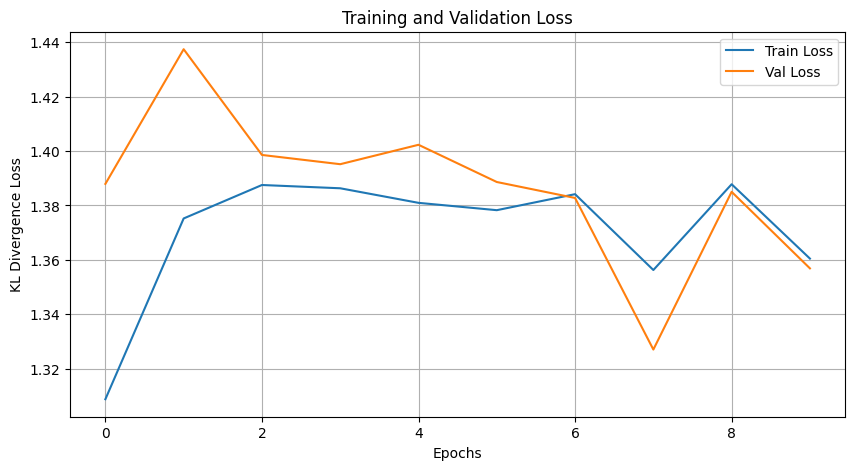

In [5]:
from torch.utils.data import DataLoader, Subset, random_split
import torch.optim as optim

# --- CONFIGURATION ---
NUM_SAMPLES = 10000  # Total pool of data to draw from
TRAIN_RATIO = 0.8  # 80% for training, 20% for validation
BATCH_SIZE = 8
EPOCHS = 10        # Increased slightly to see the trend
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Initialize full dataset
full_dataset = HMSSpectrogramDataset(csv_file='/kaggle/input/hms-harmful-brain-activity-classification/train.csv', spectrogram_dir='/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms')

# 2. Subset first, then split
# This allows you to control the total data used (100, 500, etc.)
indices = np.arange(NUM_SAMPLES)
main_subset = Subset(full_dataset, indices)

train_size = int(TRAIN_RATIO * len(main_subset))
val_size = len(main_subset) - train_size

train_dataset, val_dataset = random_split(main_subset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4  # Uses 4 CPU cores to feed the GPU
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Model, Loss, Optimizer
model = HybridSpectrogramModel(num_classes=6).to(DEVICE)
criterion = nn.KLDivLoss(reduction='batchmean') #Loss f'n
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- TRAINING & VALIDATION LOOP ---
best_val_loss = float('inf') # Initialize with infinity
# Initialize lists to store history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(torch.log_softmax(outputs, dim=1), targets)
        loss.backward()
        optimizer.step()

        _, acc = calculate_metrics(outputs, targets)
        
        train_loss += loss.item()
        train_acc += acc

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(torch.log_softmax(outputs, dim=1), targets)

            _, acc = calculate_metrics(outputs, targets)

            val_loss += loss.item()
            val_acc += acc
    
    avg_train = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)
    avg_val = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # Store the results
    history['train_loss'].append(avg_train)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(avg_val)
    history['val_acc'].append(avg_val_acc)
    
    # --- SAVE LOGIC ---
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), f'effnet-b0_{NUM_SAMPLES}_e{EPOCHS}_best.pth')
        print(f"Epoch {epoch+1}: New best validation loss ({avg_val:.4f})! Model saved.")
    # ------------------

    # --- SAVE CHECKPOINT --- #
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val,
    }, f'effnet-b0_{NUM_SAMPLES}_e{EPOCHS}_checkpoint.pth')

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")


print("Training cycle with validation complete!")

# --- After the loop finishes, plot it ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluating the Model

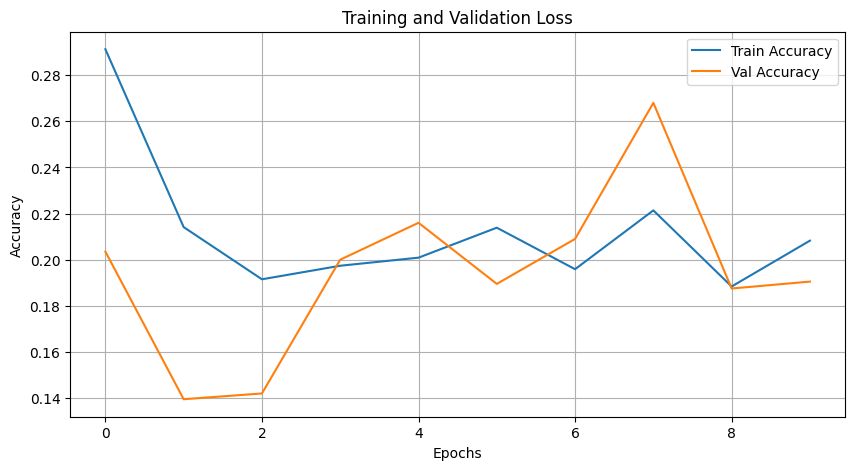

In [6]:
# Displaying the Accuracy per Epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Call the output function
print_prediction_table(model, val_loader, DEVICE, num_samples=5)


           MODEL PREDICTION SAMPLES
Type       | SZR   | LPD   | GPD   | LRDA  | GRDA  | OTH  
-------------------------------------------------------
Actual     | 0.00 | 0.00 | 0.00 | 0.60 | 0.00 | 0.40
Predict    | 0.20 | 0.13 | 0.07 | 0.15 | 0.21 | 0.24
-------------------------------------------------------
Actual     | 0.00 | 0.00 | 0.00 | 0.00 | 1.00 | 0.00
Predict    | 0.20 | 0.13 | 0.07 | 0.15 | 0.21 | 0.24
-------------------------------------------------------
Actual     | 0.00 | 0.00 | 0.00 | 0.00 | 0.40 | 0.60
Predict    | 0.20 | 0.13 | 0.07 | 0.15 | 0.21 | 0.24
-------------------------------------------------------
Actual     | 0.00 | 0.00 | 0.00 | 0.00 | 1.00 | 0.00
Predict    | 0.20 | 0.13 | 0.07 | 0.15 | 0.21 | 0.24
-------------------------------------------------------
Actual     | 1.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
Predict    | 0.20 | 0.13 | 0.07 | 0.15 | 0.21 | 0.24
-------------------------------------------------------


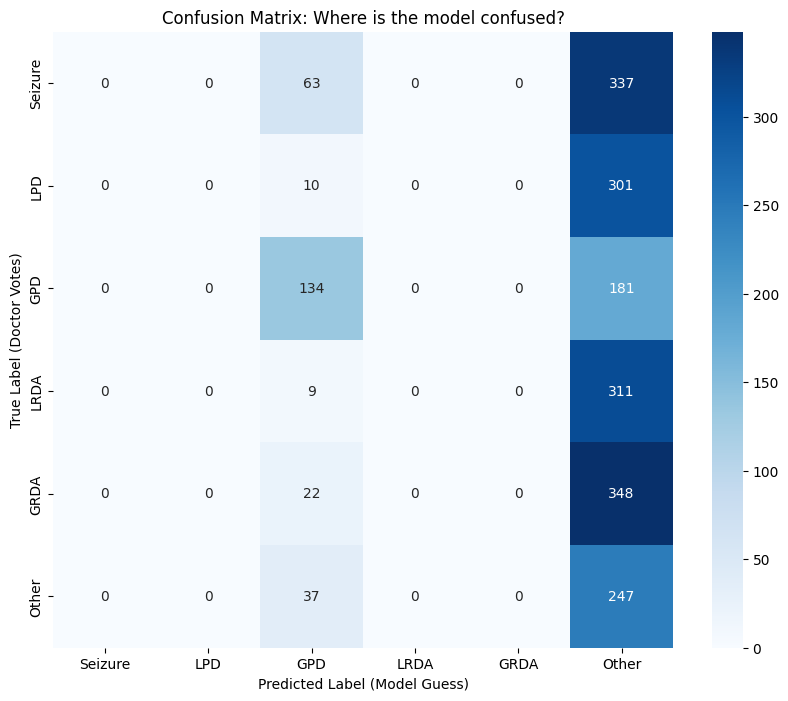

In [8]:
# Confusion Matrix
plot_confusion_matrix(model, val_loader, DEVICE)

### Next Steps for CNN
* Scale to full dataset (with left over points for validation and training)
* Improve accuracy (figure out why we are only getting two classes out of six)
* Play with hyperparameters (similar projects have used 100 epochs)
* Weigh loss function to punish when it misses a seizure (Gen AI recommendation)

For prediction: <br>

* Train CNN as feature extractor for LSTM (do a small proof of concept before scaling up classifier CNN, to save on computational resources)
* Measure performance of feature extraction with loss function

### Code for Loading the Trained Model

In [9]:
"""
#Loading model for later
# 1. Recreate the model structure
loaded_model = HybridSpectrogramModel(num_classes=6)

# 2. Load the state dictionary
loaded_model.load_state_dict(torch.load('best_model.pth'))

# 3. Move to device and set to evaluation mode
loaded_model.to(DEVICE)
loaded_model.eval()
"""

"\n#Loading model for later\n# 1. Recreate the model structure\nloaded_model = HybridSpectrogramModel(num_classes=6)\n\n# 2. Load the state dictionary\nloaded_model.load_state_dict(torch.load('best_model.pth'))\n\n# 3. Move to device and set to evaluation mode\nloaded_model.to(DEVICE)\nloaded_model.eval()\n"